In [2]:
import duckdb

# 生成文件列表的 SQL 查询
query_parts = [f"SELECT * FROM 'snowset-main.parquet/part.{i}.parquet'" for i in range(1, 11)]
full_query = " UNION ALL ".join(query_parts)

sf_all = duckdb.query(full_query).df()
sf_all

,index,queryId,warehouseId,databaseId,createdTime,endTime,durationTotal,durationExec,durationControlPlane,durationCompiling,...,profDmlRso,profHjRso,profBufRso,profFlatRso,profBloomRso,profAggRso,profBandRso,profPercentileRso,profUdtfRso,memoryUsed
0,34592,3557608506176594623,5044390069886297302,6362816185965271304,2018-03-04 12:40:47.622,2018-03-04 12:40:48.956,1334,226,923,161,...,0,101,0,0,0,0,0,0,0,141497504
1,34593,8466253792800591363,5044390069886297302,6362816185965271304,2018-03-04 08:40:47.873,2018-03-04 08:40:49.543,1670,814,300,532,...,297,0,0,0,0,0,0,0,0,347146264
2,34594,4910373243439115051,6303915986812137782,8858239961191194931,2018-03-04 16:45:48.330,2018-03-04 16:45:49.800,678,130,141,383,...,0,0,0,0,0,0,0,0,0,50939136
3,34595,4754234368842078534,6303915986812137782,8858239961191194931,2018-03-04 02:45:36.579,2018-03-04 02:45:37.161,582,185,185,194,...,0,101,0,0,0,0,0,0,0,144516256
4,34596,4311446852227941847,5044390069886297302,6362816185965271304,2018-03-04 17:38:17.836,2018-03-04 17:38:20.779,2943,2283,521,114,...,495,0,0,0,0,0,0,0,0,174793760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345915,380515,7106294109356217392,483532010532309028,926888291117852485,2018-02-26 17:45:06.198,2018-02-26 17:45:09.313,3115,1256,1490,299,...,932,0,0,0,0,0,0,0,0,114725472
345916,380516,8715831823423222320,3682821424417252214,2354262135085035772,2018-02-28 00:47:02.485,2018-02-28 00:47:03.237,752,140,81,498,...,102,0,0,0,0,0,0,0,0,29982784
345917,380517,4991423399948371142,483532010532309028,1777576237209649300,2018-02-24 12:23:04.743,2018-02-24 12:23:07.688,2945,774,305,1833,...,99,118,0,0,103,0,0,0,0,309883552
345918,380518,7152036321041544827,483532010532309028,2361950998418776419,2018-02-28 14:49:21.439,2018-02-28 14:49:35.940,14501,3017,282,1723,...,3183,249,0,0,0,0,0,0,0,1020907312


/tmp/ipykernel_2367/3561278997.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  march_1st['5_minute'] = march_1st['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/3561278997.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  march_1st['5_minute'] = march_1st['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/3561278997.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start='2018-03-01', end='2018-03-02', freq='5T')[:-1]


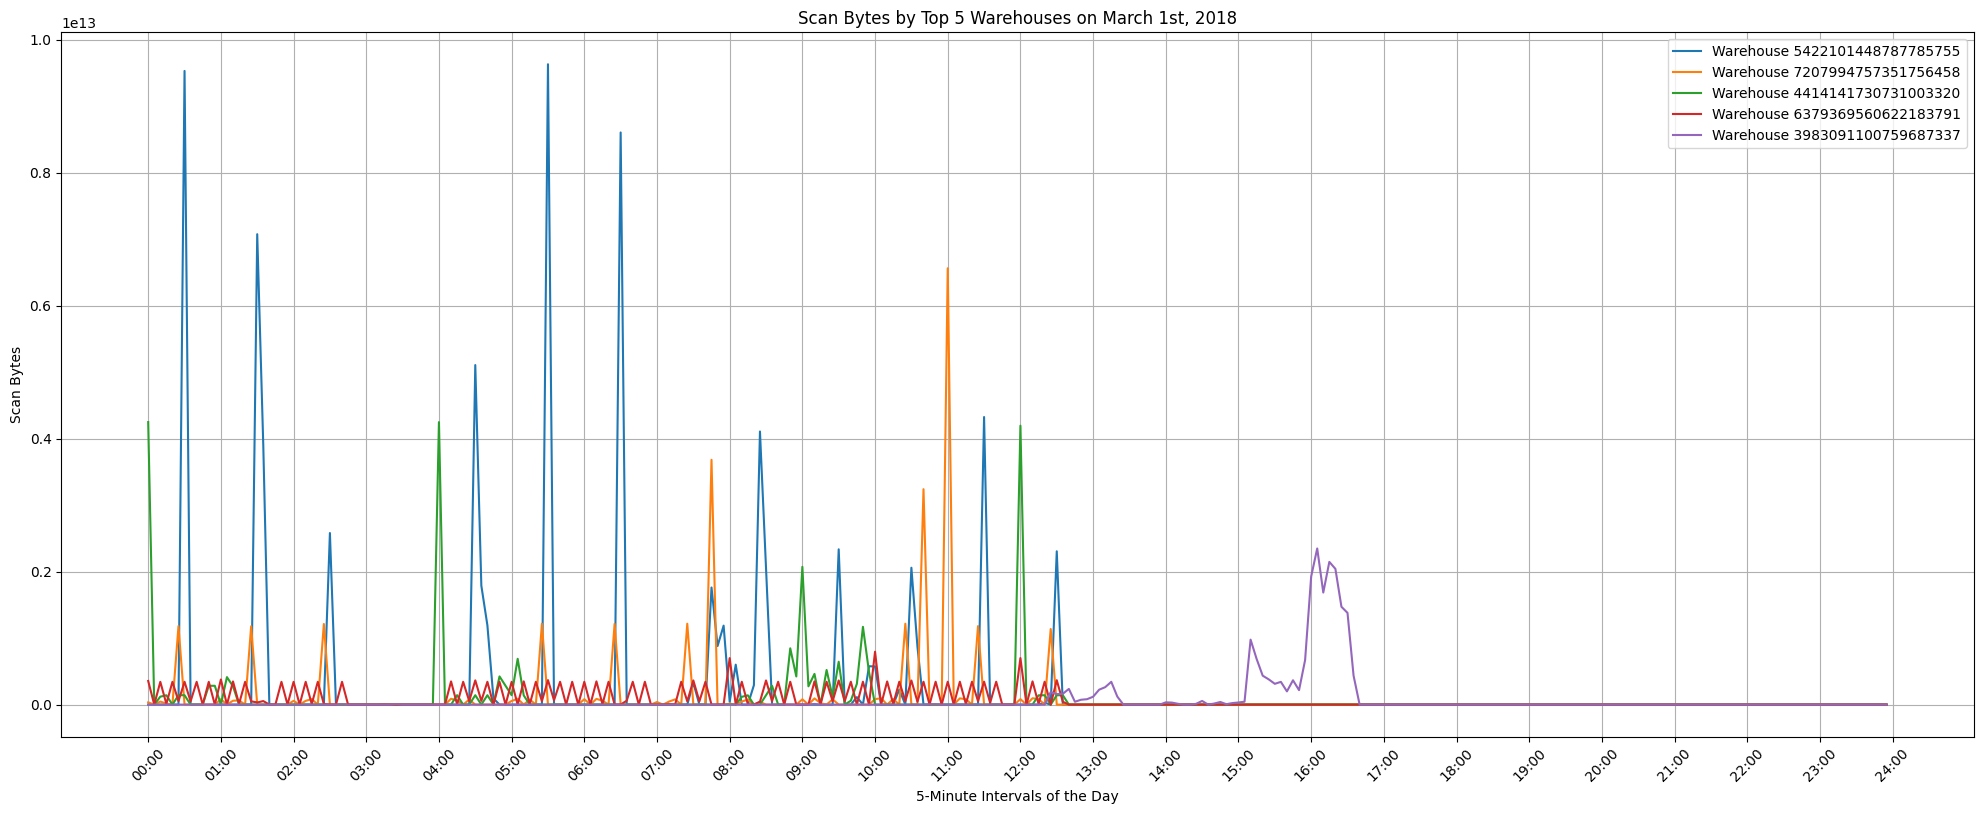

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
query_parts = [f"SELECT * FROM 'snowset-main.parquet/part.{i}.parquet'" for i in range(1, 11)]
full_query = " UNION ALL ".join(query_parts)
sf_all = duckdb.query(full_query).df()

# 转换时间列
sf_all['createdTime'] = pd.to_datetime(sf_all['createdTime'])
sf_all['endTime'] = pd.to_datetime(sf_all['endTime'])

# 筛选2018年3月1号的数据
march_1st = sf_all[
    (sf_all['createdTime'].dt.date == pd.Timestamp('2018-03-01').date()) |
    (sf_all['endTime'].dt.date == pd.Timestamp('2018-03-01').date())
]

# 找出扫描字节数最多的5个仓库
top_warehouses = march_1st.groupby('warehouseId')['scanBytes'].sum().nlargest(5).index.tolist()

# 按5分钟聚合扫描字节数
march_1st['5_minute'] = march_1st['createdTime'].dt.floor('5T')
warehouse_5minutely_scan = march_1st[march_1st['warehouseId'].isin(top_warehouses)].groupby(['warehouseId', '5_minute'])['scanBytes'].sum().reset_index()

# 为了确保24小时都有数据点，创建完整的时间序列
full_time_range = pd.date_range(start='2018-03-01', end='2018-03-02', freq='5T')[:-1]

# 绘图
plt.figure(figsize=(20, 8))
for warehouse in top_warehouses:
    warehouse_data = warehouse_5minutely_scan[warehouse_5minutely_scan['warehouseId'] == warehouse]
    
    # 重建完整的时间序列
    full_series = pd.Series(0, index=full_time_range)
    warehouse_series = warehouse_data.set_index('5_minute')['scanBytes']
    full_series.update(warehouse_series)
    
    plt.plot(range(len(full_series)), full_series.values, label=f'Warehouse {warehouse}')

plt.title('Scan Bytes by Top 5 Warehouses on March 1st, 2018')
plt.xlabel('5-Minute Intervals of the Day')
plt.ylabel('Scan Bytes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(np.linspace(0, len(full_time_range), 25), 
           [f'{i:02d}:00' for i in range(25)], rotation=45)
plt.show()

/tmp/ipykernel_2367/1340594337.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/1340594337.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/1340594337.py:41: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=date, end=pd.Timestamp(date) + pd.Timedelta(days=1), freq='5T')[:-1]
/tmp/ipykernel_2367/1340594337.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_data['5_minute'] 

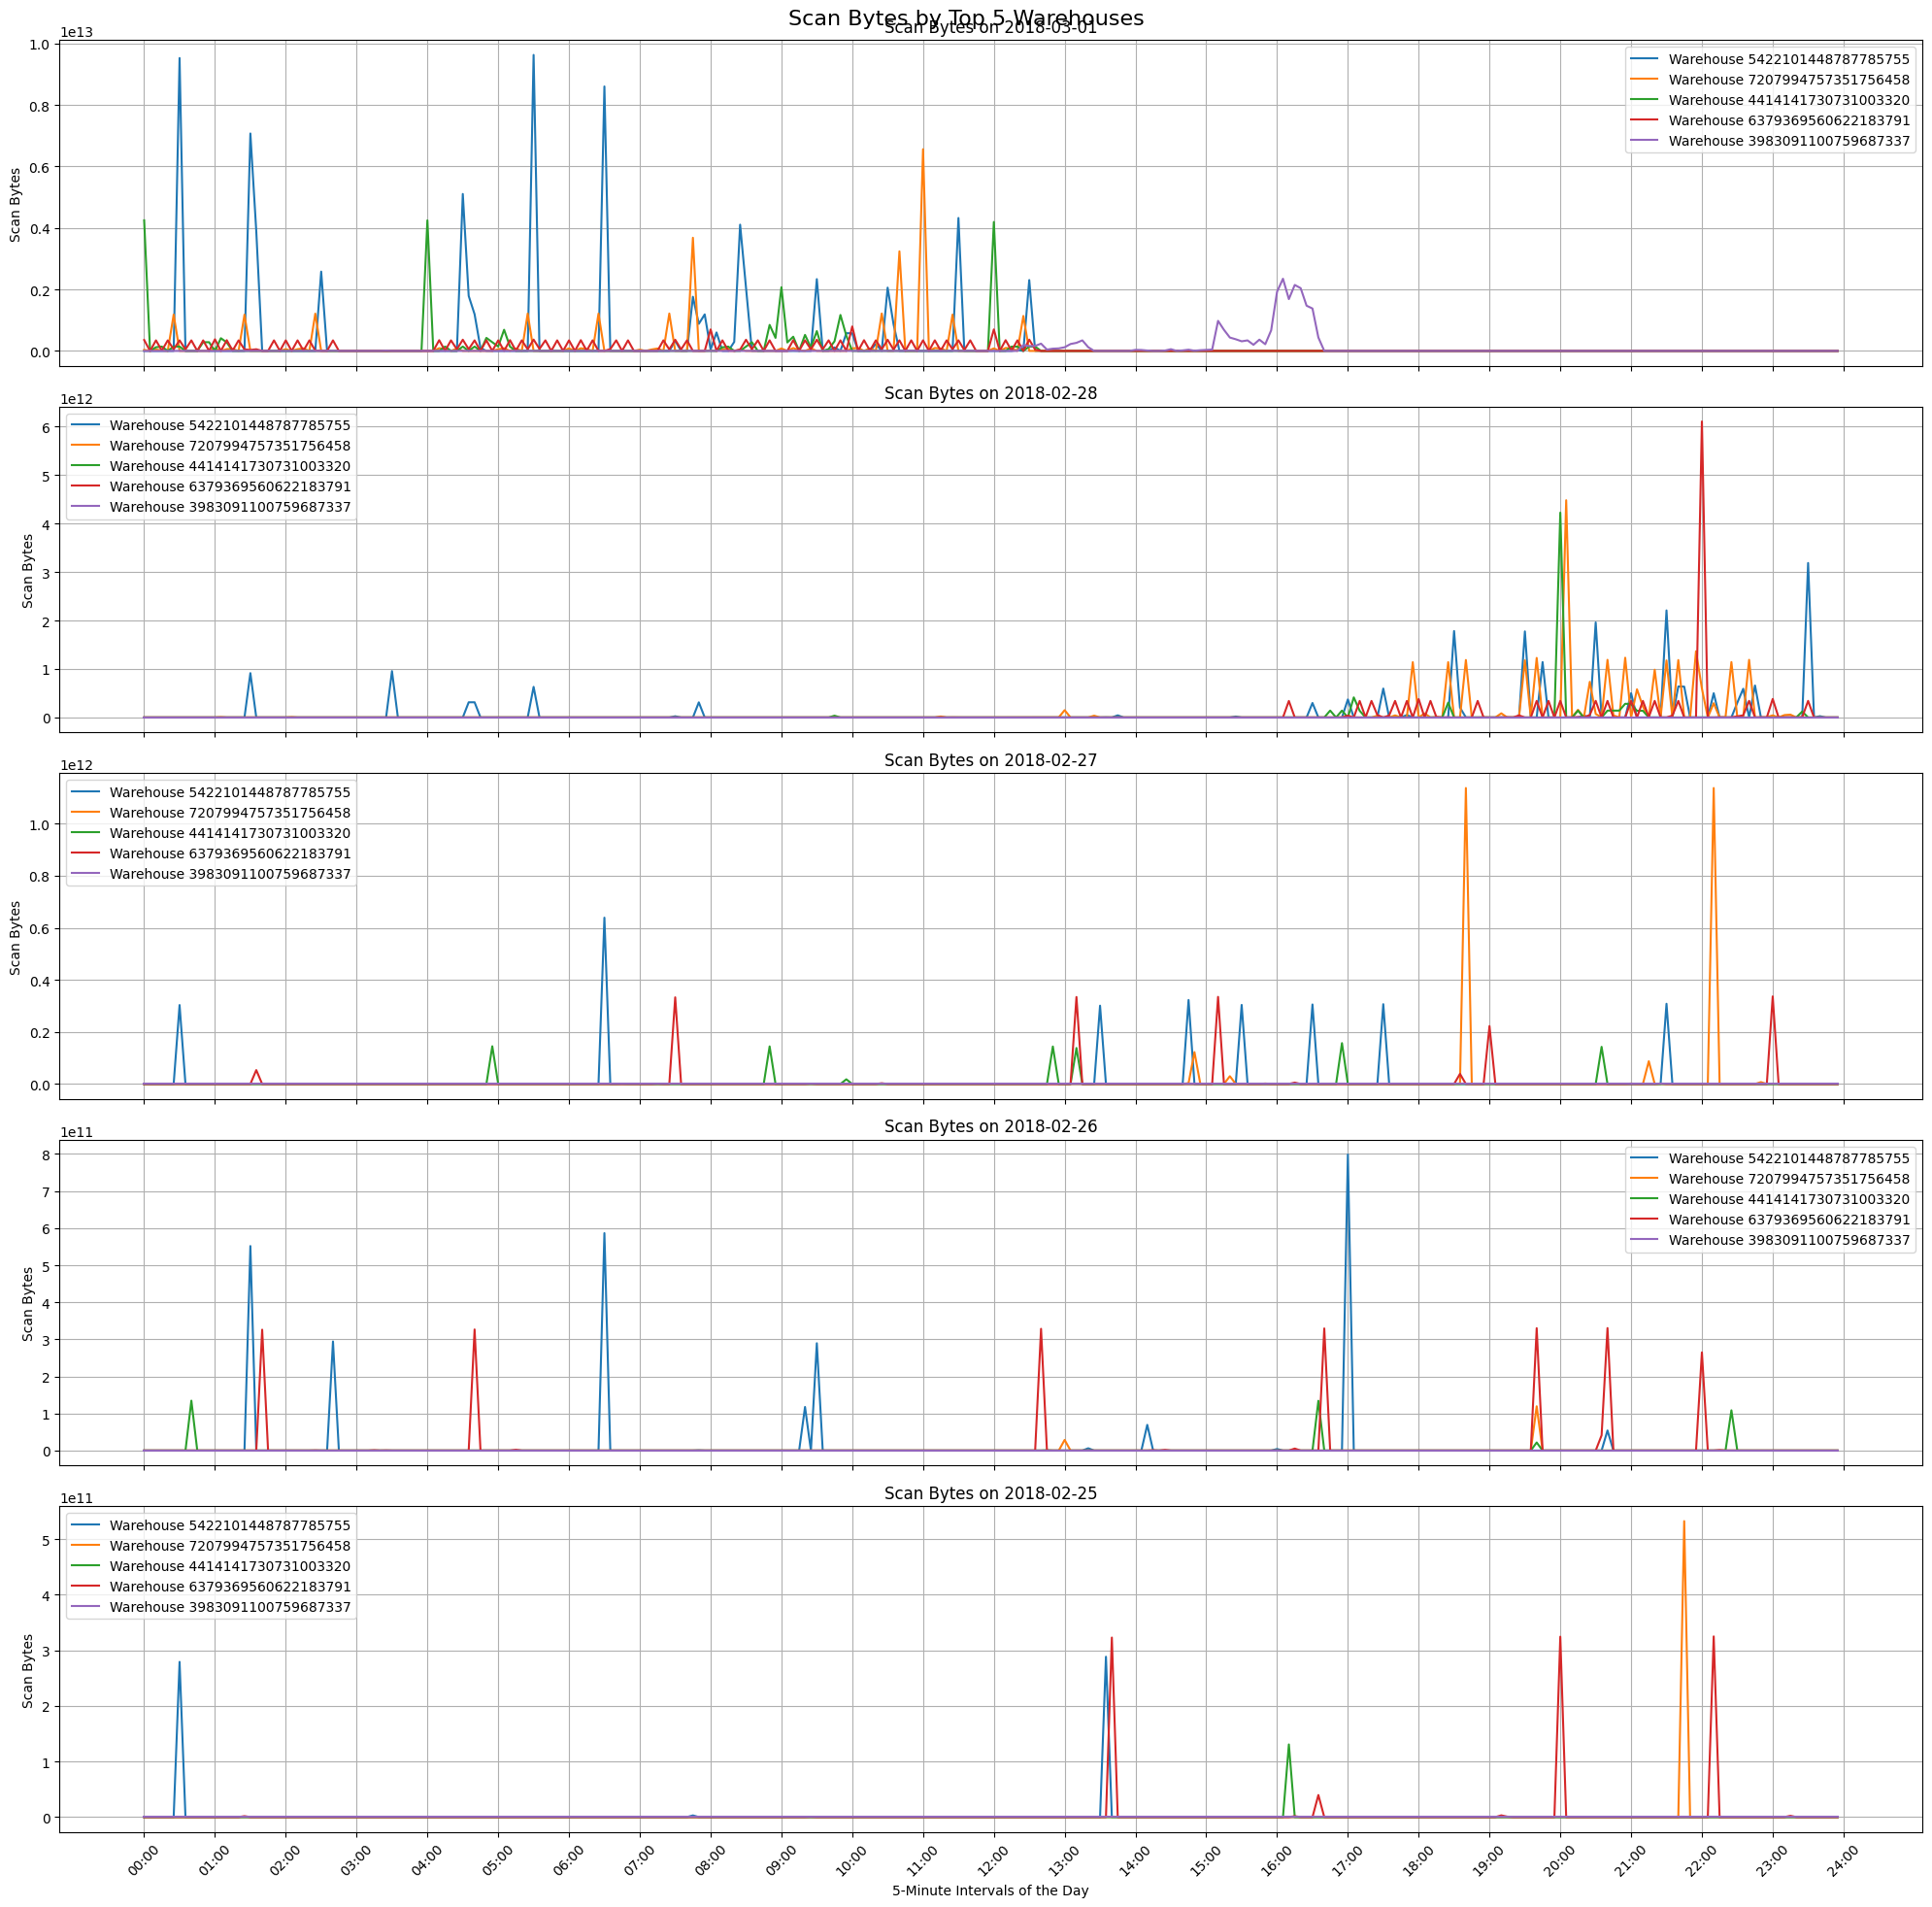

In [5]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
query_parts = [f"SELECT * FROM 'snowset-main.parquet/part.{i}.parquet'" for i in range(1, 11)]
full_query = " UNION ALL ".join(query_parts)
sf_all = duckdb.query(full_query).df()

# 转换时间列
sf_all['createdTime'] = pd.to_datetime(sf_all['createdTime'])
sf_all['endTime'] = pd.to_datetime(sf_all['endTime'])

# 首先找出3月1号扫描字节数最多的5个仓库
march_1st = sf_all[
    (sf_all['createdTime'].dt.date == pd.Timestamp('2018-03-01').date()) |
    (sf_all['endTime'].dt.date == pd.Timestamp('2018-03-01').date())
]
top_warehouses = march_1st.groupby('warehouseId')['scanBytes'].sum().nlargest(5).index.tolist()

# 定义要展示的日期
dates_to_plot = ['2018-03-01', '2018-02-28', '2018-02-27', '2018-02-26', '2018-02-25']

# 创建子图
fig, axes = plt.subplots(len(dates_to_plot), 1, figsize=(20, 4*len(dates_to_plot)), sharex=True)
fig.suptitle('Scan Bytes by Top 5 Warehouses', fontsize=16)

for idx, date in enumerate(dates_to_plot):
    # 筛选特定日期的数据
    day_data = sf_all[
        (sf_all['createdTime'].dt.date == pd.Timestamp(date).date()) |
        (sf_all['endTime'].dt.date == pd.Timestamp(date).date())
    ]
    
    # 按5分钟聚合扫描字节数
    day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
    warehouse_5minutely_scan = day_data[day_data['warehouseId'].isin(top_warehouses)].groupby(['warehouseId', '5_minute'])['scanBytes'].sum().reset_index()
    
    # 为了确保24小时都有数据点，创建完整的时间序列
    full_time_range = pd.date_range(start=date, end=pd.Timestamp(date) + pd.Timedelta(days=1), freq='5T')[:-1]
    
    # 在对应的子图上绘制
    ax = axes[idx]
    for warehouse in top_warehouses:
        warehouse_data = warehouse_5minutely_scan[warehouse_5minutely_scan['warehouseId'] == warehouse]
        
        # 重建完整的时间序列
        full_series = pd.Series(0, index=full_time_range)
        warehouse_series = warehouse_data.set_index('5_minute')['scanBytes']
        full_series.update(warehouse_series)
        
        ax.plot(range(len(full_series)), full_series.values, label=f'Warehouse {warehouse}')
    
    ax.set_title(f'Scan Bytes on {date}')
    ax.set_ylabel('Scan Bytes')
    ax.legend()
    ax.grid(True)

# 在最后一个子图上设置x轴标签
axes[-1].set_xlabel('5-Minute Intervals of the Day')
axes[-1].set_xticks(np.linspace(0, len(full_time_range), 25))
axes[-1].set_xticklabels([f'{i:02d}:00' for i in range(25)], rotation=45)

plt.tight_layout()
plt.show()

观察发现，这些模式往往是叠加出现的

/tmp/ipykernel_2367/3873127176.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/3873127176.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
/tmp/ipykernel_2367/3873127176.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=date, end=pd.Timestamp(date) + pd.Timedelta(days=1), freq='5T')[:-1]
/tmp/ipykernel_2367/3873127176.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_data['5_minute'] 

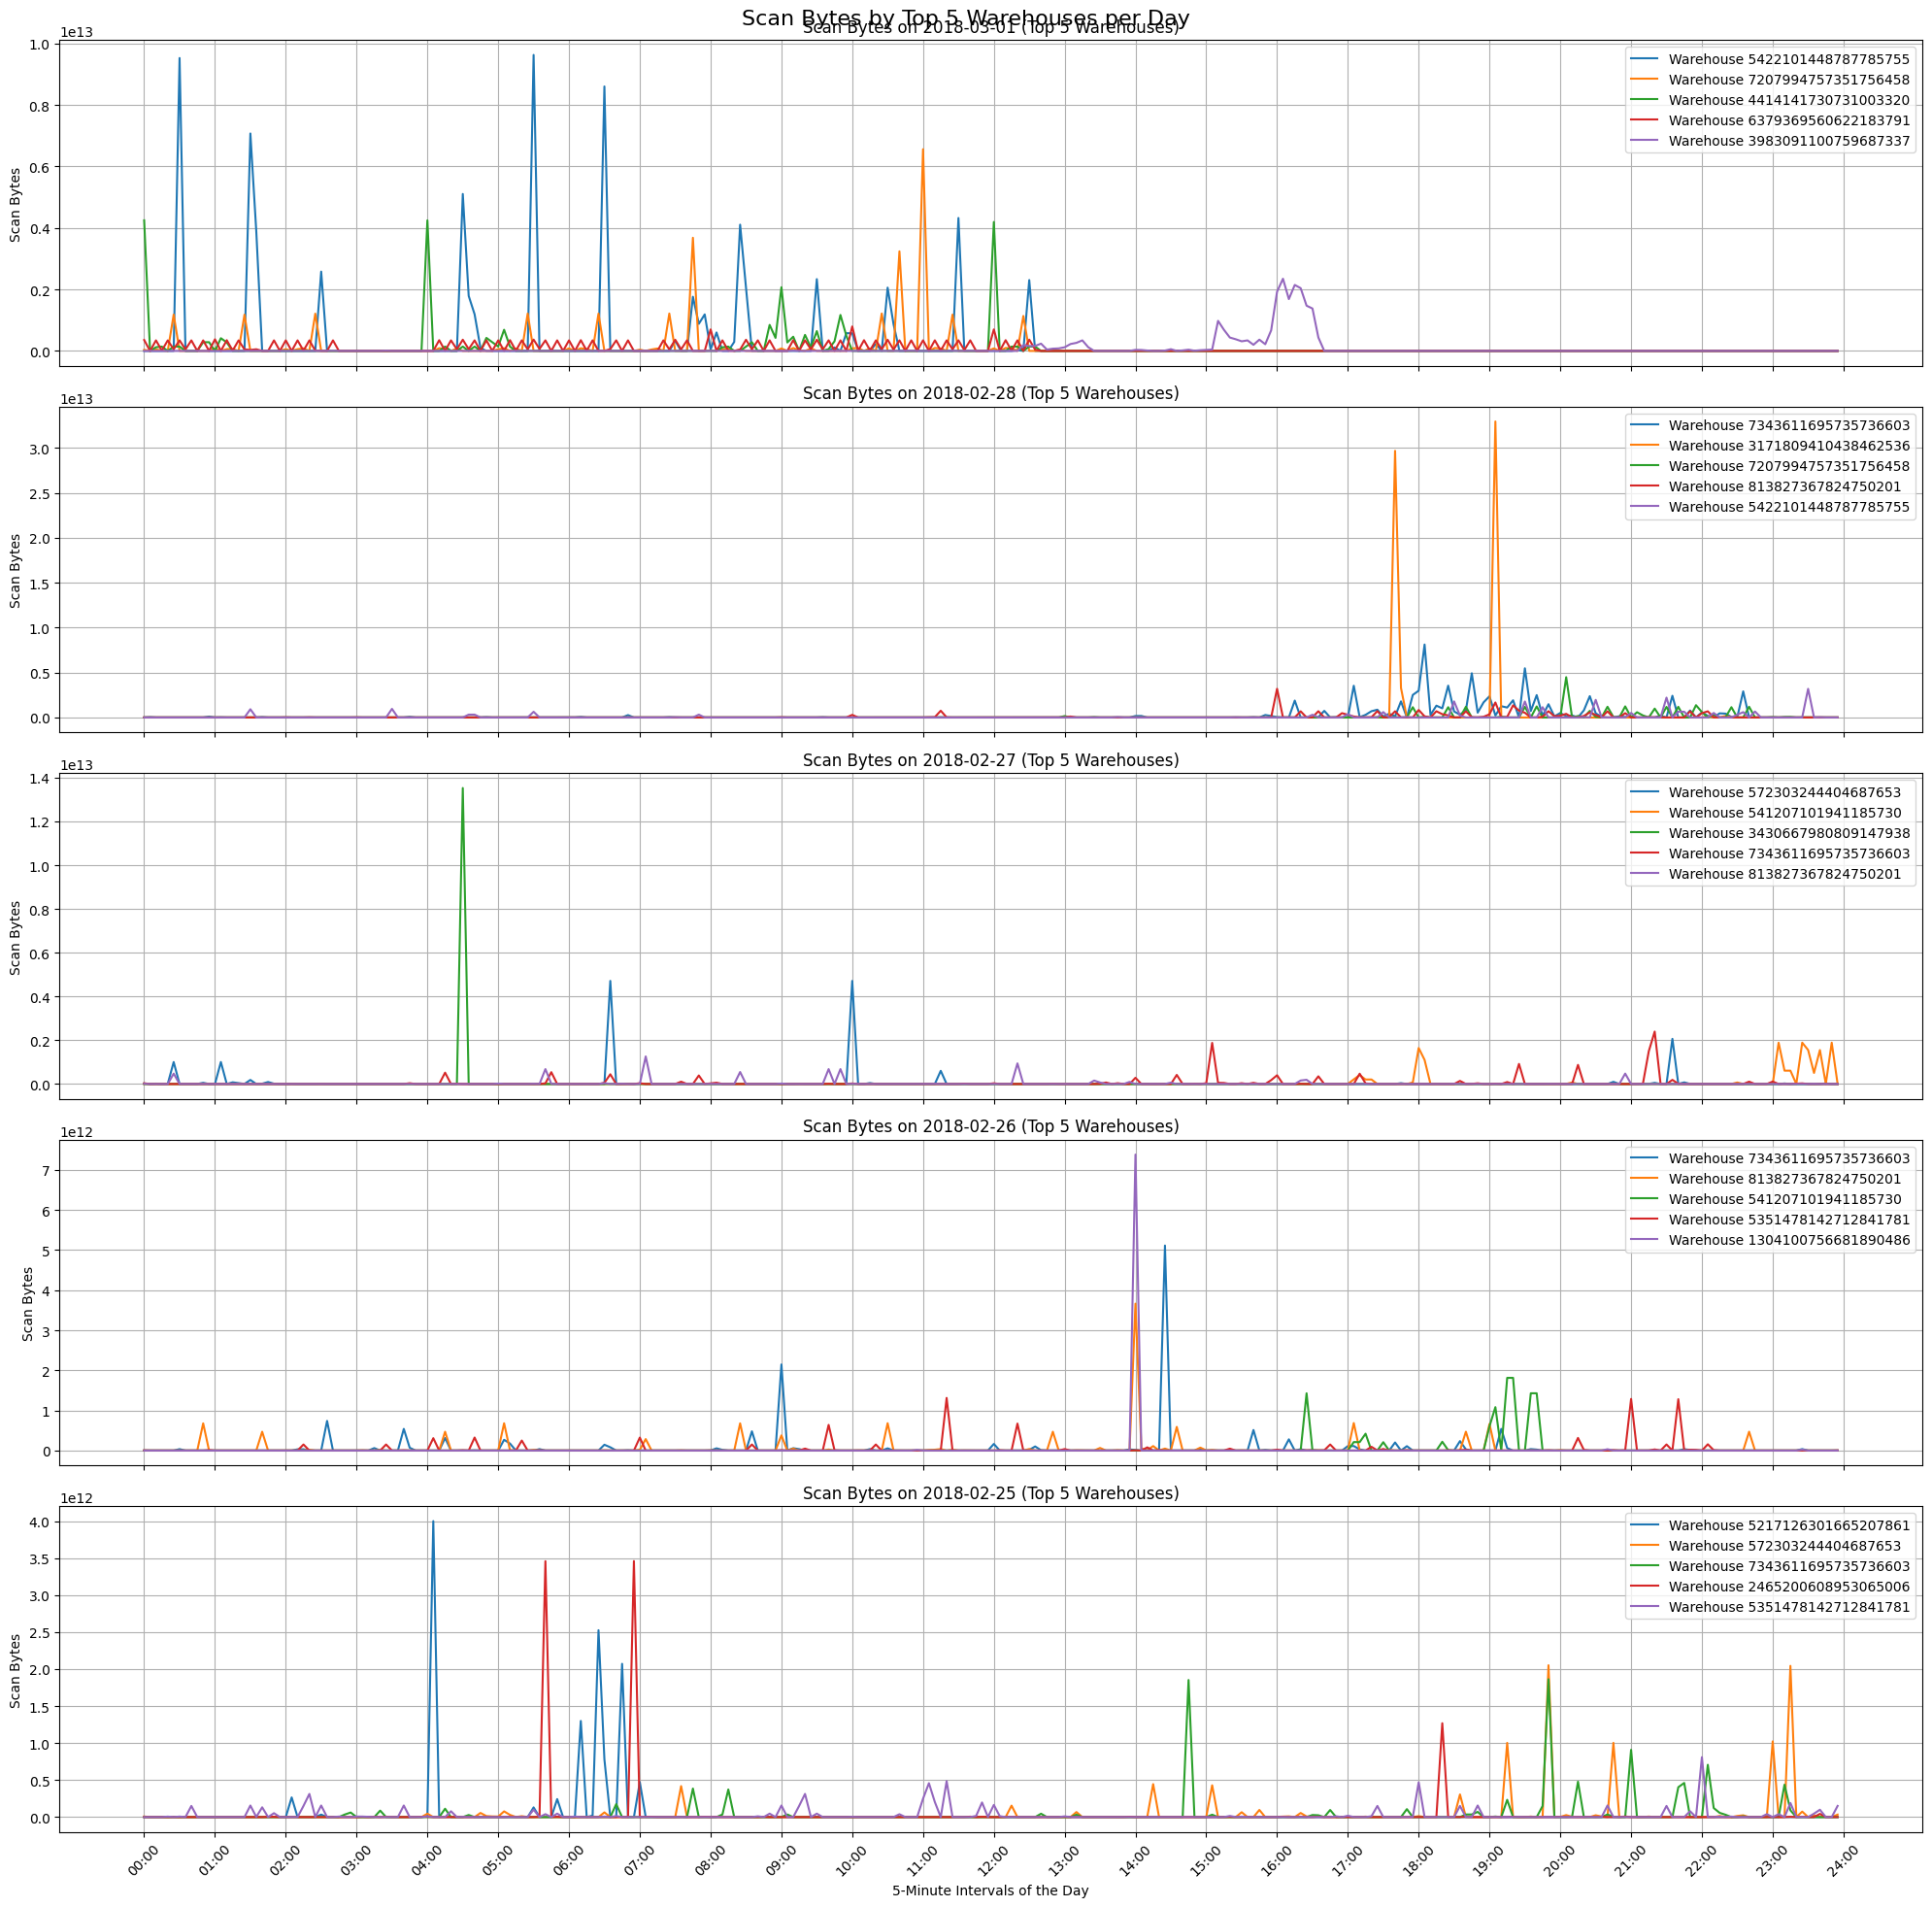

In [6]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
query_parts = [f"SELECT * FROM 'snowset-main.parquet/part.{i}.parquet'" for i in range(1, 11)]
full_query = " UNION ALL ".join(query_parts)
sf_all = duckdb.query(full_query).df()

# 转换时间列
sf_all['createdTime'] = pd.to_datetime(sf_all['createdTime'])
sf_all['endTime'] = pd.to_datetime(sf_all['endTime'])

# 定义要展示的日期
dates_to_plot = ['2018-03-01', '2018-02-28', '2018-02-27', '2018-02-26', '2018-02-25']

# 创建子图
fig, axes = plt.subplots(len(dates_to_plot), 1, figsize=(20, 4*len(dates_to_plot)), sharex=True)
fig.suptitle('Scan Bytes by Top 5 Warehouses per Day', fontsize=16)

for idx, date in enumerate(dates_to_plot):
    # 筛选特定日期的数据
    day_data = sf_all[
        (sf_all['createdTime'].dt.date == pd.Timestamp(date).date()) |
        (sf_all['endTime'].dt.date == pd.Timestamp(date).date())
    ]
    
    # 找出当天扫描字节数最多的5个仓库
    top_warehouses = day_data.groupby('warehouseId')['scanBytes'].sum().nlargest(5).index.tolist()
    
    # 按5分钟聚合扫描字节数
    day_data['5_minute'] = day_data['createdTime'].dt.floor('5T')
    warehouse_5minutely_scan = day_data[day_data['warehouseId'].isin(top_warehouses)].groupby(['warehouseId', '5_minute'])['scanBytes'].sum().reset_index()
    
    # 为了确保24小时都有数据点，创建完整的时间序列
    full_time_range = pd.date_range(start=date, end=pd.Timestamp(date) + pd.Timedelta(days=1), freq='5T')[:-1]
    
    # 在对应的子图上绘制
    ax = axes[idx]
    for warehouse in top_warehouses:
        warehouse_data = warehouse_5minutely_scan[warehouse_5minutely_scan['warehouseId'] == warehouse]
        
        # 重建完整的时间序列
        full_series = pd.Series(0, index=full_time_range)
        warehouse_series = warehouse_data.set_index('5_minute')['scanBytes']
        full_series.update(warehouse_series)
        
        ax.plot(range(len(full_series)), full_series.values, label=f'Warehouse {warehouse}')
    
    ax.set_title(f'Scan Bytes on {date} (Top 5 Warehouses)')
    ax.set_ylabel('Scan Bytes')
    ax.legend()
    ax.grid(True)

# 在最后一个子图上设置x轴标签
axes[-1].set_xlabel('5-Minute Intervals of the Day')
axes[-1].set_xticks(np.linspace(0, len(full_time_range), 25))
axes[-1].set_xticklabels([f'{i:02d}:00' for i in range(25)], rotation=45)

plt.tight_layout()
plt.show()

In [15]:
unique_warehouse_ids = sf_all['warehouseId'].unique()
print(unique_warehouse_ids)

[5044390069886297302 6303915986812137782 2306249779961677997
 1558798446833043198 8372946418414461671 8182774881063385652
 7954625141408938366 9137748609271758813 3554176433012304146
 8056190644601083270 7891774171123969424  127838927447833194
 1304100756681890486 8865234946653547835 1890180489335197062
 6965596363389953206 4566059884658954458 5738967600715927266
 3935012469029068210 1808168017366077491 2402414691803287283
 4820843680047209114 1052723000525734273 4521920227430629158
 2090840980287508285 6328605299045833917 5145760350610366053
 9066841199229799095 3683995838094312218 1920032723612295023
 7955588313762753653 6416476652656852991 5958599495372359729
 6064287453321410798 8710708141266537360 6025240988369907361
 4287181337241377893 3682821424417252214 6314450707633251764
  483532010532309028 3032251027042056849 1771751338429382502
  988133534026957316  247999856655522217  610182046151967910
   64067798006253974 2816414103111279299 2434611136251602799
 2543545816433696797 301